# **Initialization**

## Install dependencies

In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !apt-get update
    !apt install python-opengl
    !apt install ffmpeg
    !apt install xvfb
    !pip install PyVirtualDisplay==3.0
    !pip install gymnasium[classic_control]
    from pyvirtualdisplay import Display

    # Start virtual display
    dis = Display(visible=0, size=(400, 400))
    dis.start()

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,196 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,226 kB]
Get:13 http://security.ubunt

## Import Dependencies

In [2]:
import os
from typing import Dict, List, Tuple
import math, random

import gym
import gymnasium as gymnasium
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


import base64
import glob
import io
import os


import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F


from IPython.display import HTML, display, clear_output



#**Implementation**

## **Show recorded video**
The following functions are used in order to show in a video the obtained results

In [3]:
def ipython_show_video(path: str) -> None:
    """Show a video at `path` within IPython Notebook."""
    if not os.path.isfile(path):
        raise NameError("Cannot access: {}".format(path))

    video = io.open(path, "r+b").read()
    encoded = base64.b64encode(video)

    display(HTML(
        data="""
        <video width="320" height="240" alt="test" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4"/>
        </video>
        """.format(encoded.decode("ascii"))
    ))

def remove_videos (video_folder: str):
    list_of_files = glob.glob(os.path.join(video_folder, "*.mp4"))
    for video in list_of_files:
      try:
          os.remove(video)
      except:
          print("Error while deleting file : ", video)

def show_latest_video(video_folder: str) -> str:
    """Show the most recently recorded video from video folder."""
    list_of_files = glob.glob(os.path.join(video_folder, "*.mp4"))
    print("files: ", list_of_files )
    latest_file = max(list_of_files, key=os.path.getctime)
    ipython_show_video(latest_file)
    return latest_file

def show_all_videos(video_folder: str) -> str:
    """Show all the videos recorded."""
    list_of_files = glob.glob(os.path.join(video_folder, "*.mp4"))
    print("files: ", list_of_files )
    for video in list_of_files:
      ipython_show_video(video)
    print("Played:", video)


## Autograd Variable

In [4]:
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs)

## Replay Buffer

In [5]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)

        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done

    def __len__(self):
        return len(self.buffer)

In [24]:
import numpy as np
import random
from collections import deque
      #New Version of the Replay Buffer without Experience Relay
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.alpha = alpha  # Hyperparameter, which is responsible for priority
        self.buffer = deque(maxlen=capacity)
        self.priorities = []
        self.position = 0

    # Determine max priority
    def push(self, state, action, reward, next_state, done):

      max_priority = max(self.priorities) if self.priorities else 1.0

      if len(self.buffer) < self.capacity:
          # add state and priority
          self.buffer.append((state, action, reward, next_state, done))
          self.priorities.append(max_priority)
      else:
          # If the Buffer is full we replace state and priority
          self.buffer[self.position] = (state, action, reward, next_state, done)
          self.priorities[self.position] = max_priority

      # Refresh position
      self.position = (self.position + 1) % self.capacity


    def sample(self, batch_size):
      # Synchronisation of Buffer and priorities
      assert len(self.buffer) == len(self.priorities), "Buffer and priorities must have the same length."

      # here we are calculating possibilities based on priorities
      priorities = np.array(self.priorities, dtype=np.float32) ** self.alpha
      probabilities = priorities / np.sum(priorities)

      # doing sampling with possibilities
      indices = np.random.choice(len(self.buffer), batch_size, p=probabilities, replace=False)
      experiences = [self.buffer[i] for i in indices]

      return experiences, indices


    def update_priorities(self, indices, td_errors):
        # Refresh the possibilities after TD-Fehler
        for idx, td_error in zip(indices, td_errors):
            self.priorities[idx] = abs(td_error) + 1e-5  # small number in case error=0

    def __len__(self):
        return len(self.buffer)


*###* Testing Replay Buffer

In [ ]:
# We build a Replay buffer for 5 elements
rB = ReplayBuffer(5)

# We are going to add 8 elements
for i in range(8):
  rB.push(i,i,i,i,i)
print("We add 8 elements but there are only ", len(rB), "\nrB: ", rB.buffer)

# We are going to add another value
rB.push(10,10,10,10,10)
print("\nAfter we add a new element the buffer is: ", rB.buffer)

# No we are going to see are sampled some experiences
mini_batch = rB.sample(2)
print("\n The sampled elemenst: ", mini_batch )

mini_batch = rB.sample(3)
print("\n The sampled elemenst: ", mini_batch )


We add 8 elements but there are only  5 
rB:  deque([(array([3]), 3, 3, array([3]), 3), (array([4]), 4, 4, array([4]), 4), (array([5]), 5, 5, array([5]), 5), (array([6]), 6, 6, array([6]), 6), (array([7]), 7, 7, array([7]), 7)], maxlen=5)

After we add a new element the buffer is:  deque([(array([4]), 4, 4, array([4]), 4), (array([5]), 5, 5, array([5]), 5), (array([6]), 6, 6, array([6]), 6), (array([7]), 7, 7, array([7]), 7), (array([10]), 10, 10, array([10]), 10)], maxlen=5)

 The sampled elemenst:  (array([5, 7]), (5, 7), (5, 7), array([5, 7]), (5, 7))

 The sampled elemenst:  (array([6, 7, 4]), (6, 7, 4), (6, 7, 4), array([6, 7, 4]), (6, 7, 4))


## Cart Pole Environment

In [7]:
env_id = "CartPole-v0"
env = gymnasium.make(env_id, render_mode="rgb_array")

/usr/local/lib/python3.10/dist-packages/gymnasium/envs/registration.py:517: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


In [8]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.show()

## Epsilon greedy exploration
Epsilon value is dynamic. It starts with 1.0 value (exploration) and little by little it is going to decay until 0.01 (exploitation)

In [9]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

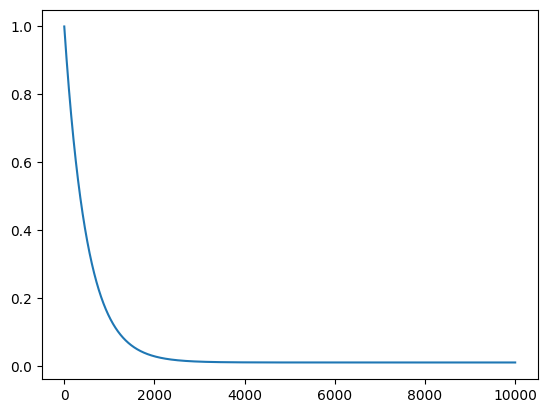

In [10]:
plt.plot([epsilon_by_frame(i) for i in range(10000)])

## Deep Q Network

In [25]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, env.action_space.n)
        )

        self.optimizer = optim.Adam(self.parameters())
        self.replay_buffer = PrioritizedReplayBuffer(1000)
        self.batch_size = 32
        self.gamma = 0.99


    def get_epsilon_value(self, frame_idx):
      epsilon_start = 1.0
      epsilon_final = 0.01
      epsilon_decay = 500

      epsilon = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)
      return epsilon(frame_idx)


    def forward(self, x):
        return self.layers(x)


    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(state).unsqueeze(0), requires_grad=False)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].item()
        else:
            action = random.randrange(env.action_space.n)
        return action


    def update_target(self, target_model):
      target_model.load_state_dict(self.state_dict())




    def compute_td_loss_our(self, target_model):

      state, action, reward, next_state, done = self.replay_buffer.sample(self.batch_size)

      # Convert those numpy arrays to tensors. It is neccesary to work with Pytorch
      states_tensor      = Variable(torch.FloatTensor(np.float32(state)))       # current_state S
      actions_tensor     = Variable(torch.LongTensor(action))                   # action A
      next_states_tensor = Variable(torch.FloatTensor(np.float32(next_state)))  # next_state S'

      # The approximated q_values of each current state
      q_values_tensor      = self.forward(states_tensor) # Q(S, A, W)

      # The approximated q_values of each next state calculated with the current_model and the target_model
      next_q_values_current_model_tensor = self.forward(next_states_tensor) # Q(S', A', W)
      next_q_values_target_model_tensor = target_model.forward(next_states_tensor) # Q(S', A', W')

      # Convert the approximated next_states' q_values to numpy array. We are going to work with these arrays
      next_q_values_current_model = next_q_values_current_model_tensor.detach().numpy();
      next_q_values_target_model = next_q_values_target_model_tensor.detach().numpy();
      expected_q_value = np.zeros(self.batch_size)

      # TODO
      # input: next_q_values_current_model is a numpy array. In each element are stored all the approximated q values for the next state calculated with the current_model
      # input: next_q_values_target_model is a numpy array. In each element are stored all the approximated q values for the next state calculated with the target_model
      # input: reward is a numpy array with the rewards obtained in each experience of the mini_batch (batch_size)
      # output: expected_q_value is a numpy array. You have to store in each position the target value of each experience using next_q_values_target_model and reward elements
      # note: all these numpy arrays has the same length: the length of the mini_batch (batch_size)
      #
      # for all the elements on the batch size
      #  calculate the target expected value and store in expected_q_value

      for i in range(self.batch_size):
        next_q_value = 0
        if not(done[i]):
          next_q_value = max(next_q_values_target_model[i])

          # with current model
          #next_q_value = max(next_q_values_current_model[i])

          # with current model action and target model approximation
          #next_action = np.argmax(next_q_values_current_model[i])
          #next_q_value = next_q_values_target_model[i][next_action]

        expected_q_value[i] = reward[i] + self.gamma*next_q_value

      # END TODO

      # Prepare data for the loss function
      q_value = q_values_tensor.gather(1, actions_tensor.unsqueeze(1)).squeeze(1)
      expected_q_values = torch.tensor(expected_q_value)

      # Loss function: to know how good the weights are
      lossMSE = nn.MSELoss()
      loss = lossMSE(q_value.float(), expected_q_values.float())

      # Based on the results of the loss function, the weights are updated with gradient descent
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

      return loss



    def compute_td_error(self, q_value, reward, gamma, next_q):
      return (q_value - (reward + gamma * next_q))




    # TODO
    # Method to train the agent
    def train(self, env):
      num_frames = 25000
      losses = []
      all_rewards = []
      episode_reward = 0
      target_model = DQN(env.observation_space.shape[0], env.action_space.n)
      state, info = env.reset()

      for frame_idx in range(1, num_frames + 1):
        epsilon = self.get_epsilon_value(frame_idx)
        action = self.act(state, epsilon)

        next_state, reward, done, truncated, info = env.step(action)
        self.replay_buffer.push(state, action, reward, next_state, done)

        state = next_state
        episode_reward += reward

        if done or truncated:
            state, info = env.reset()
            all_rewards.append(episode_reward)
            episode_reward = 0

        if len(self.replay_buffer) > self.batch_size:
            # Sampling from the Replay-Buffer, so we are picking some examples from the buffer.
            experiences, indices = self.replay_buffer.sample(self.batch_size)
            states, actions, rewards, next_states, dones = zip(*experiences)

            # Convert those numpy arrays to tensors. It is neccesary to work with Pytorch.
            states_np = np.array(states, dtype=np.float32)
            actions_np = np.array(actions, dtype=np.int64)
            rewards_np = np.array(rewards, dtype=np.float32)
            next_states_np = np.array(next_states, dtype=np.float32)
            dones_np = np.array(dones, dtype=np.float32)

            # Converting  NumPy-Arrays to PyTorch-tensors
            states_tensor = torch.from_numpy(states_np)
            actions_tensor = torch.from_numpy(actions_np)
            rewards_tensor = torch.from_numpy(rewards_np)
            next_states_tensor = torch.from_numpy(next_states_np)
            dones_tensor = torch.from_numpy(dones_np)

            # Calculating the q values for actual and for the next state
            q_values = self(states_tensor)
            next_q_values_target = target_model(next_states_tensor)

            # Calculating the next max q value and expected values
            max_next_q_values = torch.max(next_q_values_target, dim=1)[0]
            expected_q_values = rewards_tensor + self.gamma * max_next_q_values * (1 - dones_tensor)

            # q values for actions
            q_values_for_actions = q_values.gather(1, actions_tensor.unsqueeze(1)).squeeze(1)

            # calculating the loss
            loss = nn.MSELoss()(q_values_for_actions, expected_q_values)


            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # calculating finald td errors and update
            td_errors = (q_values_for_actions - expected_q_values).detach().numpy()
            self.replay_buffer.update_priorities(indices, np.abs(td_errors))

            losses.append(loss.item())

        # Visualising every Frames
        if frame_idx % 200 == 0:
            plot(frame_idx, all_rewards)

        # Refresh Targetmodell every 100 Frames
        if frame_idx % 100 == 0:
            self.update_target(target_model)



    # This method runs one episode and generates a video to observe the result
    def test(self,env):
        video_folder="videos"

        remove_videos(video_folder=video_folder)

        # we are going to work over envVideo.
        envVideo = gymnasium.wrappers.RecordVideo(env, video_folder=video_folder)

        done = False #It is used to control if the episode is finished, if it is finished the environment must be reset
        state, info = envVideo.reset()

        total_reward = 0
        while not(done):
            action = self.act(state, 0)
            next_state, reward, done, truncated, info = envVideo.step(action)
            state = next_state
            total_reward +=reward
            if done or truncated:
              break
        envVideo.close()
        print("rew: ", total_reward)
        show_all_videos(video_folder=video_folder)



### Train the agent

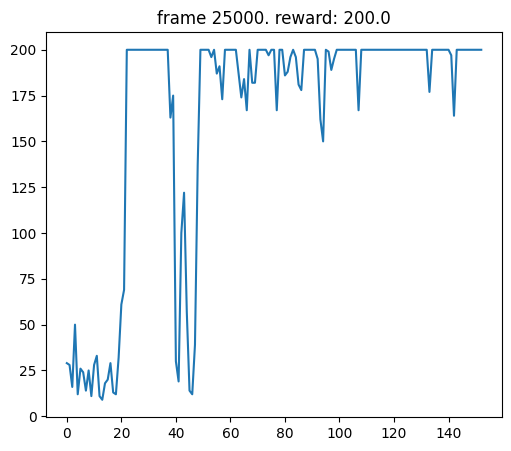

In [26]:
current_model = DQN(env.observation_space.shape[0], env.action_space.n)
current_model.train(env)

### Test the agent

In [27]:
current_model.test(env)

/usr/local/lib/python3.10/dist-packages/moviepy/config_defaults.py:1: DeprecationWarning: invalid escape sequence '\P'
  """
/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred

rew:  200.0
files:  ['videos/rl-video-episode-0.mp4']


Played: videos/rl-video-episode-0.mp4
